In [ ]:
!unzip data.zip

In [1]:
#@title 2. 필수 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# ML 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder # (여기서는 get_dummies 사용)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost 모델 사용 (테이블 데이터 회귀 문제에 강력함)
from xgboost import XGBRegressor

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 시각화 기본 설정
sns.set_style('whitegrid')
plt.rc('figure', figsize=(12, 6))

print("Libraries imported.")

Libraries imported.


In [2]:
#@title 3. 데이터 로드 및 기본 정보 확인

# ----------------------------------------------------------------------
# [중요!] 사용자의 Google Drive에 업로드된 CSV 파일의 *전체 경로*를 입력하세요.
# (예: '/content/drive/MyDrive/data/House_Rent_Dataset.csv')
# ----------------------------------------------------------------------
DATA_PATH = "./House_Rent_Dataset.csv" # <--- 이 경로를 수정하세요

try:
    df = pd.read_csv(DATA_PATH)
    print(f"Data loaded successfully from: {DATA_PATH}")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}")
    print("Please upload the CSV file to Google Drive and update the DATA_PATH variable.")
except Exception as e:
    print(f"An error occurred: {e}")

# 데이터 샘플 및 정보 확인
print("\n--- Data Head ---")
print(df.head())


Data loaded successfully from: ./House_Rent_Dataset.csv
Dataset shape: (4746, 12)

--- Data Head ---
    Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4             South Dum Dum  Kolkata       Unfurnished         Bachelors   

   Bathroom Point of Contact  
0         2    Conta

In [3]:
print("\n--- Data Info (Checking Nulls and Dtypes) ---")
df.info()


--- Data Info (Checking Nulls and Dtypes) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [4]:
print("\n--- Missing Values Check ---")
print(df.isnull().sum()) # 이 데이터셋은 결측치가 없음


--- Missing Values Check ---
Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64


Text(0, 0.5, 'Frequency')

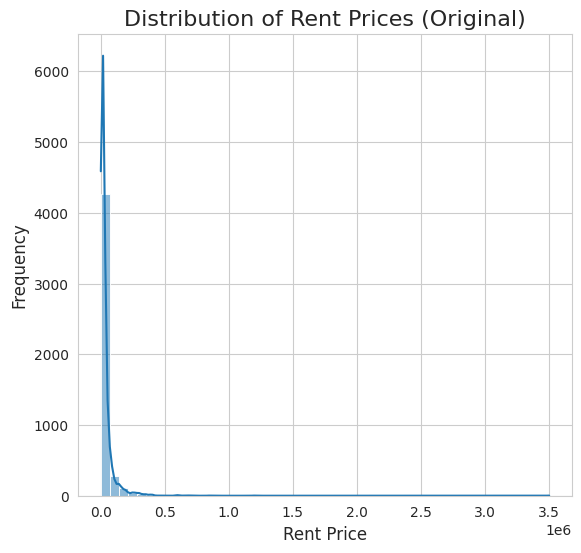

In [5]:
#@title 4. [EDA 보강] Target 변수(Rent) 분포 분석 (영문 Plot)

# 1. 원본 임대료(Rent) 분포
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Rent'], kde=True, bins=50)
plt.title('Distribution of Rent Prices (Original)', fontsize=16)
plt.xlabel('Rent Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

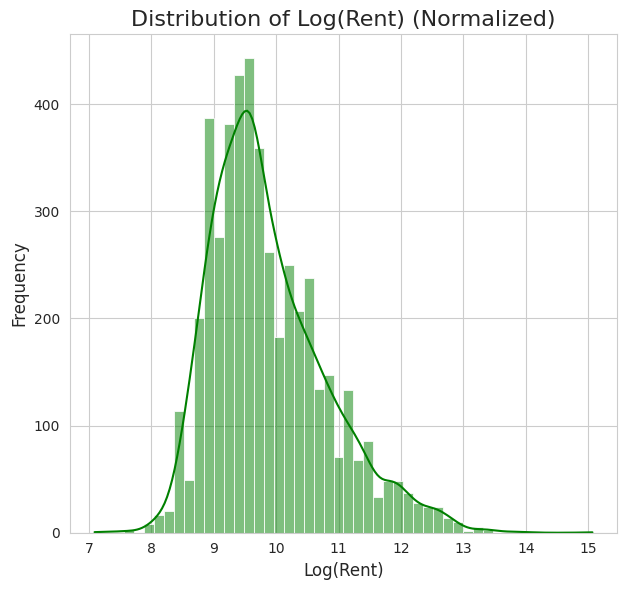

Analysis: Original rent price is heavily right-skewed. Log-transformed rent (Log_Rent) is used for modeling.


In [6]:
# 2. 로그 변환(Log Transform) 임대료 분포
# (가격 데이터는 매우 skewed 되어 있으므로, np.log1p (log(1+x))로 변환하여 정규화)
df['Log_Rent'] = np.log1p(df['Rent'])

plt.subplot(1, 2, 2)
sns.histplot(df['Log_Rent'], kde=True, bins=50, color='green')
plt.title('Distribution of Log(Rent) (Normalized)', fontsize=16)
plt.xlabel('Log(Rent)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

print("Analysis: Original rent price is heavily right-skewed. Log-transformed rent (Log_Rent) is used for modeling.")



Text(0, 0.5, 'Log(Rent)')

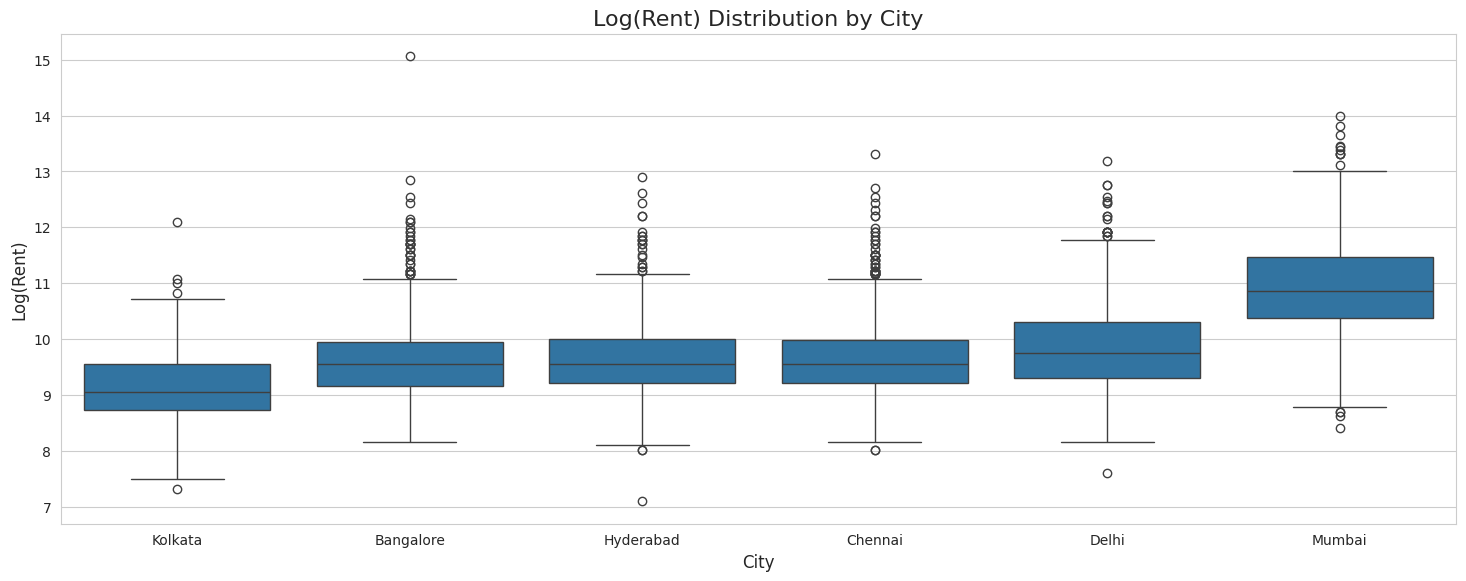

In [7]:
#@title 5. [EDA 보강] 주요 피처별 임대료 분석 (Box Plots - 영문)

# (로그 변환된 임대료(Log_Rent)를 사용하여 시각화해야 이상치(outlier) 때문에 그래프가 망가지는 것을 방지)

plt.figure(figsize=(18, 14))

# 1. 도시(City) vs 임대료
plt.subplot(2, 1, 1)
city_order = df.groupby('City')['Log_Rent'].median().sort_values().index
sns.boxplot(data=df, x='City', y='Log_Rent', order=city_order)
plt.title('Log(Rent) Distribution by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Log(Rent)', fontsize=12)

Text(0, 0.5, 'Log(Rent)')

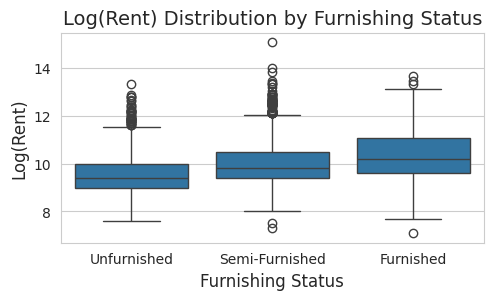

In [8]:
# 2. 가구 상태(Furnishing Status) vs 임대료
plt.subplot(2, 2, 3)
furnish_order = df.groupby('Furnishing Status')['Log_Rent'].median().sort_values().index
sns.boxplot(data=df, x='Furnishing Status', y='Log_Rent', order=furnish_order)
plt.title('Log(Rent) Distribution by Furnishing Status', fontsize=14)
plt.xlabel('Furnishing Status', fontsize=12)
plt.ylabel('Log(Rent)', fontsize=12)

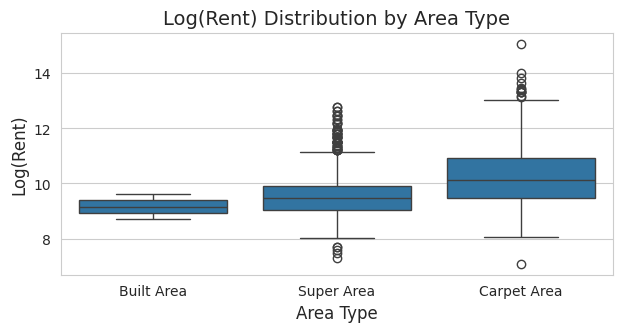

In [9]:
# 3. 면적 유형(Area Type) vs 임대료
plt.subplot(2, 2, 4)
area_order = df.groupby('Area Type')['Log_Rent'].median().sort_values().index
sns.boxplot(data=df, x='Area Type', y='Log_Rent', order=area_order)
plt.title('Log(Rent) Distribution by Area Type', fontsize=14)
plt.xlabel('Area Type', fontsize=12)
plt.ylabel('Log(Rent)', fontsize=12)

plt.tight_layout()
plt.show()

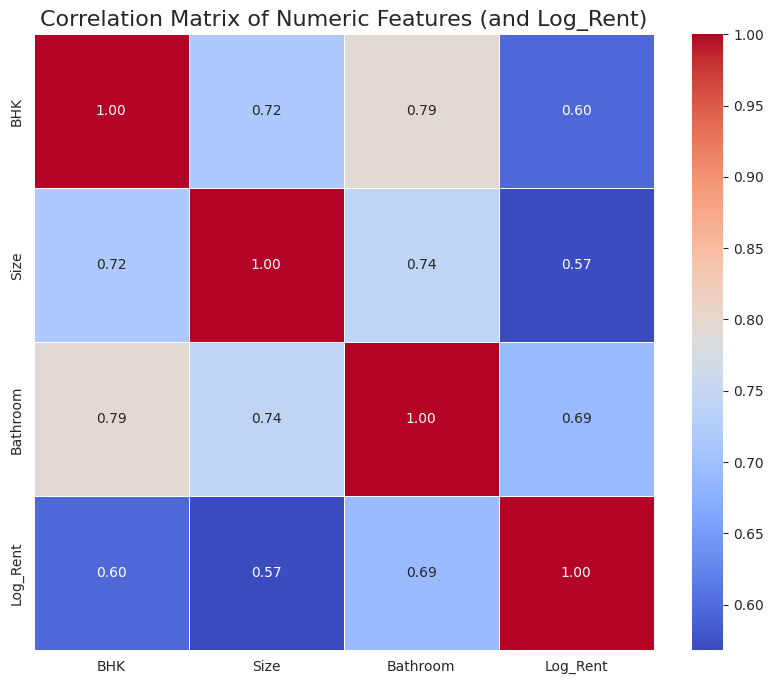

Analysis: 'Size', 'BHK', and 'Bathroom' are all positively correlated with Rent.


In [10]:
#@title 6. [EDA 보강] 수치형 피처 상관관계 (Heatmap - 영문)

# 숫자형 컬럼 + 로그 변환된 타겟을 포함하여 히트맵 생성
numeric_cols = ['BHK', 'Size', 'Bathroom', 'Log_Rent']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features (and Log_Rent)', fontsize=16)
plt.show()

print("Analysis: 'Size', 'BHK', and 'Bathroom' are all positively correlated with Rent.")


In [11]:
#@title 7. 데이터 전처리 (One-Hot Encoding) 및 X/y 분리

# 1. 불필요한 컬럼 및 원본 Rent 컬럼 제거
# (Posted On, Point of Contact 등은 예측에 불필요. Rent는 Log_Rent를 사용할 것이므로 제거)
df_processed = df.drop(columns=['Posted On', 'Point of Contact', 'Rent'])

# 2. 범주형(Categorical) 변수 One-Hot Encoding (pd.get_dummies)
# (XGBoost는 Label Encoding도 처리 가능하지만, get_dummies가 더 안전함)
categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print(f"Data shape after One-Hot Encoding: {df_processed.shape}")

# 3. X(Features) / y(Target) 분리
y = df_processed['Log_Rent']
X = df_processed.drop(columns=['Log_Rent'])

print(f"X (Features) shape: {X.shape}")
print(f"y (Target) shape: {y.shape}")


Data shape after One-Hot Encoding: (4746, 2728)
X (Features) shape: (4746, 2727)
y (Target) shape: (4746,)


In [16]:
#@title 8. 모델 학습 (Train/Test 분리 및 XGBoost)

# 1. 학습/테스트 데이터 분리 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# 2. XGBoost 회귀 모델 정의 (XGBRegressor)
# (하이퍼파라미터는 기본값을 사용하거나 튜닝할 수 있습니다)
xgb_model = XGBRegressor(
    n_estimators=500,     # 트리의 개수
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,            # 모든 CPU 코어 사용
)

print("Starting model training (XGBRegressor)...")


Starting model training (XGBRegressor)...


In [17]:
# 3. 모델 학습 (검증셋을 지정하여 조기 종료 활성화)
eval_set = [(X_test, y_test)]
xgb_model.fit(
    X_train,
    y_train,
    verbose=False # (True로 설정하면 학습 과정 로그 출력)
)

print("Model training finished.")

Model training finished.


In [18]:
#@title 9. [결과 분석 보강] 모델 평가 (R², MAE, RMSE)

# 1. 테스트셋 예측 (결과는 Log 스케일)
y_pred_log = xgb_model.predict(X_test)

# 2. 예측 결과를 원래 스케일(Actual Rent)로 되돌리기 (Inverse Transform)
# np.log1p()의 역함수인 np.expm1() 사용
y_pred_orig = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

# 3. 핵심 회귀 평가지표 계산 (원본 스케일 기준)
r2 = r2_score(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

print("--- Model Evaluation Metrics (on Original Scale) ---")
print(f"R-squared (R²):   {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} (평균적으로 ±{mae:.2f} 만큼 가격 예측 오차)")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



--- Model Evaluation Metrics (on Original Scale) ---
R-squared (R²):   0.7401
Mean Absolute Error (MAE): 10666.54 (평균적으로 ±10666.54 만큼 가격 예측 오차)
Root Mean Squared Error (RMSE): 32184.64


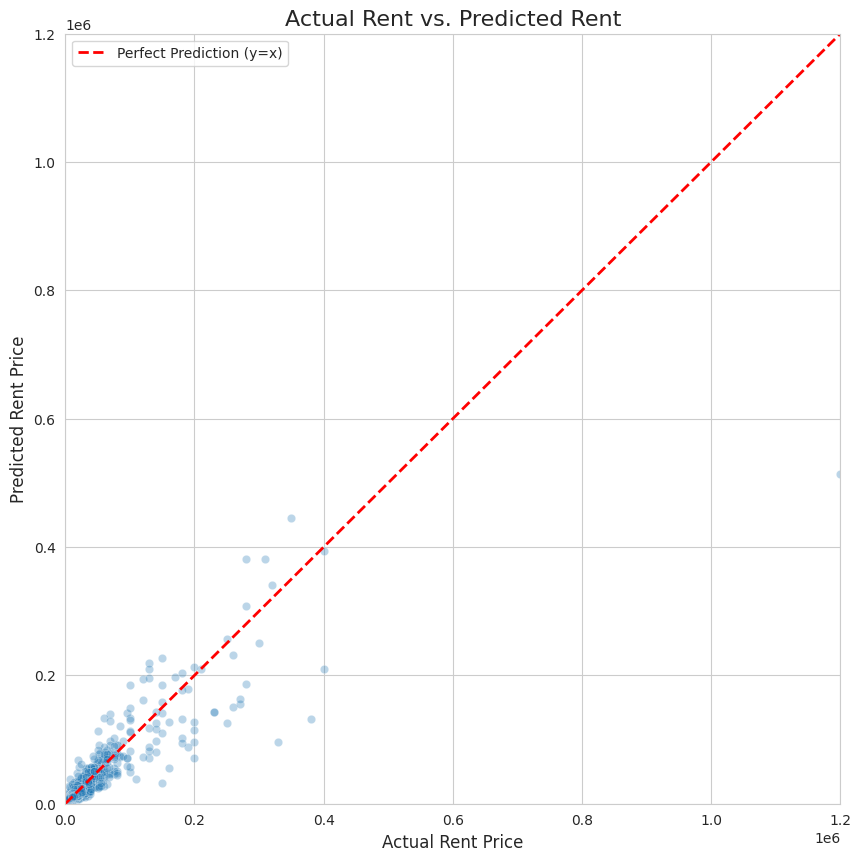

Analysis: The model's predictions align well with the actual values along the red line,
though there is higher variance (spread) for more expensive properties.


In [19]:
#@title 10. [결과 분석 보강] 실제 값 vs 예측 값 시각화 (Scatter Plot - 영문)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test_orig, y=y_pred_orig, alpha=0.3)

# 완벽한 예측을 나타내는 기준선 (y=x) 추가
max_val = max(y_test_orig.max(), y_pred_orig.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction (y=x)')

plt.title('Actual Rent vs. Predicted Rent', fontsize=16)
plt.xlabel('Actual Rent Price', fontsize=12)
plt.ylabel('Predicted Rent Price', fontsize=12)
plt.legend()
plt.axis([0, max_val, 0, max_val]) # x축과 y축 범위를 동일하게 설정
plt.grid(True)
plt.show()

print("Analysis: The model's predictions align well with the actual values along the red line,")
print("though there is higher variance (spread) for more expensive properties.")


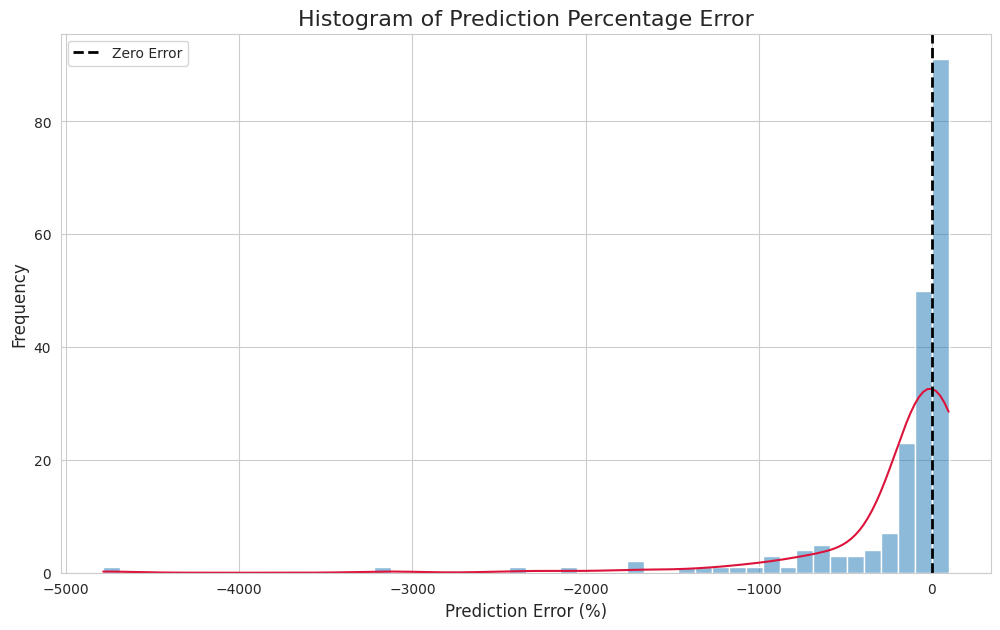


Analysis: The prediction error is centered around 0%,
meaning the model is unbiased, although a wide spread indicates varying accuracy.


In [20]:
#@title 11. [원본 코드 재구성] 예측 오차율 히스토그램 (영문 Plot)
# (원본 노트북의 마지막 스니펫 코드를 재구성 및 영문화)

# 1. 계산을 위해 DataFrame으로 변환 (원본 코드 형식과 일치)
real_df = pd.DataFrame({'Rent': y_test_orig})
pred_df = pd.DataFrame(y_pred_orig)

# 2. 백분율 오차(Percentage Error) 계산
# ( (실제값 - 예측값) / 실제값 ) * 100
percentage_error = ((real_df['Rent'] - pred_df[0]) / real_df['Rent']) * 100

# 3. 오차 분포 시각화 (Histogram)
plt.figure(figsize=(12, 7))
ax = sns.histplot(percentage_error, kde=True, bins=50)
ax.lines[0].set_color('crimson') # KDE 라인 색상 변경

plt.title('Histogram of Prediction Percentage Error', fontsize=16)
plt.xlabel('Prediction Error (%)', fontsize=12) # (Actual - Predicted) / Actual
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.show()

print("\nAnalysis: The prediction error is centered around 0%,")
print(f"meaning the model is unbiased, although a wide spread indicates varying accuracy.")